b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

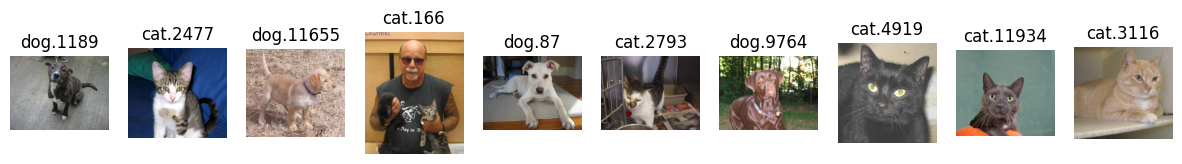

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

current_path = Path().absolute()
train_path = current_path / "original_data" / "train"

train_list = list(train_path.iterdir())

num_images_to_sample = min(10, len(train_list))

if num_images_to_sample > 0:
    pictures = random.sample(train_list, num_images_to_sample)

    labels = [path.stem.split('_')[0] for path in pictures]

    fig, axes = plt.subplots(1, num_images_to_sample, figsize=(15, 3))
    if num_images_to_sample > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax, img_path, label in zip(axes, pictures, labels):
        image = plt.imread(img_path)
        ax.imshow(image)
        ax.set_title(label)
        ax.axis("off")

    plt.show()



In [2]:
"""

# Definiera de olika sökvägarna
experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")
original_data = Path("original_data")


# Skapa mappstrukturen
experiment_small_data.mkdir(parents=True, exist_ok=True)
experiment_tiny_data.mkdir(parents=True, exist_ok=True)
(original_data / "test").mkdir(parents=True, exist_ok=True)
(original_data / "train").mkdir(parents=True, exist_ok=True)

#Skapa undermappar i experiment_small_data och experiment_tiny_data
for folder in ["test", "train", "val"]:
    (experiment_small_data / folder).mkdir(exist_ok=True)
    (experiment_tiny_data / folder).mkdir(exist_ok=True)

# bugtest så vi vet om något går fel
for item in Path(".").rglob("*"):
     print(item) 

"""

'\n\n# Definiera de olika sökvägarna\nexperiment_small_data = Path("experiment_small_data")\nexperiment_tiny_data = Path("experiment_tiny_data")\noriginal_data = Path("original_data")\n\n\n# Skapa mappstrukturen\nexperiment_small_data.mkdir(parents=True, exist_ok=True)\nexperiment_tiny_data.mkdir(parents=True, exist_ok=True)\n(original_data / "test").mkdir(parents=True, exist_ok=True)\n(original_data / "train").mkdir(parents=True, exist_ok=True)\n\n#Skapa undermappar i experiment_small_data och experiment_tiny_data\nfor folder in ["test", "train", "val"]:\n    (experiment_small_data / folder).mkdir(exist_ok=True)\n    (experiment_tiny_data / folder).mkdir(exist_ok=True)\n\n# bugtest så vi vet om något går fel\nfor item in Path(".").rglob("*"):\n     print(item) \n\n'

d) Nu ska du göra train|val|test split med följande splits:

experiment_small
* train - 1600 (800 dogs, 800 cats)
* val - 400 (200 dogs, 200 cats)
* test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
* train - 160 (80 dogs, 80 cats)
* val - 40 (20 dogs, 20 cats)
* test - 50 (25 dogs, 25 cats

In [3]:
import shutil

current_path = Path().absolute()
original_data = current_path / "original_data" / "train"
experiment_small_data = current_path / "experiment_small_data"
experiment_tiny_data = current_path / "experiment_tiny_data"

splits_info = {
    "experiment_small": {"train": 1600, "val": 400, "test": 500},
    "experiment_tiny": {"train": 160, "val": 40, "test": 50}
}

def setup_datasets(experiment_path, splits, source_data):
    experiment_path.mkdir(parents=True, exist_ok=True)

    images = list(source_data.glob("*.jpg"))
    random.shuffle(images)  

    for split_name, total_images in splits.items():
        split_path = experiment_path / split_name
        split_path.mkdir(parents=True, exist_ok=True)

        existing_images = list(split_path.glob("*.jpg"))
        num_existing = len(existing_images)
        num_needed = total_images - num_existing

        if num_needed > 0:
            images_to_move = images[:num_needed]
            images = images[num_needed:]  

            for image in images_to_move:
                shutil.move(str(image), str(split_path / image.name))
            print(f"Moved {len(images_to_move)} images to {split_path}. Total now: {num_existing + len(images_to_move)}")
        else:
            print(f"{split_name.capitalize()} split in {experiment_path.name} already has {num_existing} images, no more needed.")

setup_datasets(experiment_small_data, splits_info["experiment_small"], original_data)
setup_datasets(experiment_tiny_data, splits_info["experiment_tiny"], original_data)


Train split in experiment_small_data already has 1600 images, no more needed.
Val split in experiment_small_data already has 400 images, no more needed.
Test split in experiment_small_data already has 500 images, no more needed.
Train split in experiment_tiny_data already has 160 images, no more needed.
Val split in experiment_tiny_data already has 40 images, no more needed.
Test split in experiment_tiny_data already has 50 images, no more needed.


---

 e) Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som
ska vara one-hot encoded med 0 och 1.
* plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
* skapa lämplig plot för att kontrollera att dataseten är balanserade
* skapa lämplig plot för att kontrollera att dataseten är slumpade

In [4]:
import numpy as np
from pathlib import Path
from PIL import Image
import random
import cv2

small_train = current_path / experiment_small_data / "train"
small_test = current_path / experiment_small_data / "test"
small_val = current_path / experiment_small_data / "val"
train_list = list(small_train.iterdir())    # lsit of the paths
test_list = list(small_test.iterdir())  
val_list = list(small_val.iterdir())  

tiny_train = current_path / experiment_tiny_data / "train"
tiny_test = current_path / experiment_tiny_data / "test"
tiny_val = current_path / experiment_tiny_data / "val"
train_list_tiny = list(tiny_train.iterdir())    # lsit of the paths
test_list_tiny = list(tiny_test.iterdir())  
val_list_tiny = list(tiny_val.iterdir())  


def label_data(data):
    """Labels the lists with 1 or 0 for dog and cat"""
    labels= []
    images= []
    np.random.shuffle(data)   #shuffel to see random images
    for path in data:    # setting labels 1 for dog, 0 for cat
        label= 1 if "dog" in path.name else 0
        labels.append(label)

        image= cv2.imread(str(path))
        images.append(image)

    return images, np.array(labels)



small_data = Path("experiment_small_data") 
tiny_data = Path("experiment_tiny_data") 

# Load data
X_train_small, y_train_small = label_data(train_list)
X_test_small, y_test_small = label_data(test_list)
X_val_small, y_val_small = label_data(val_list)

X_train_tiny, y_train_tiny = label_data(train_list_tiny)
X_test_tiny, y_test_tiny = label_data(test_list_tiny)
X_val_tiny, y_val_tiny = label_data(val_list_tiny)



print("Shapes of Small Data:")
print("y_train:", y_train_small.shape)
#print("X_train:", X_train_small)
print("y_test:", y_test_small.shape)
#print("X_test:", X_test_small)
print("y_val:", y_val_small.shape)
#print("X_val:", X_val_small)

print("\nShapes of Tiny Data:")
print("y_train:", y_train_tiny.shape)
#print("X_train:", X_train_tiny)
print("y_test:", y_test_tiny.shape)
#print("X_test:", X_test_tiny)
print("y_val:", y_val_tiny.shape)
#print("X_val:", X_val_tiny)




Shapes of Small Data:
y_train: (1600,)
y_test: (500,)
y_val: (400,)

Shapes of Tiny Data:
y_train: (160,)
y_test: (50,)
y_val: (40,)


---
# 1. Bildbehandling (*)
Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

 a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

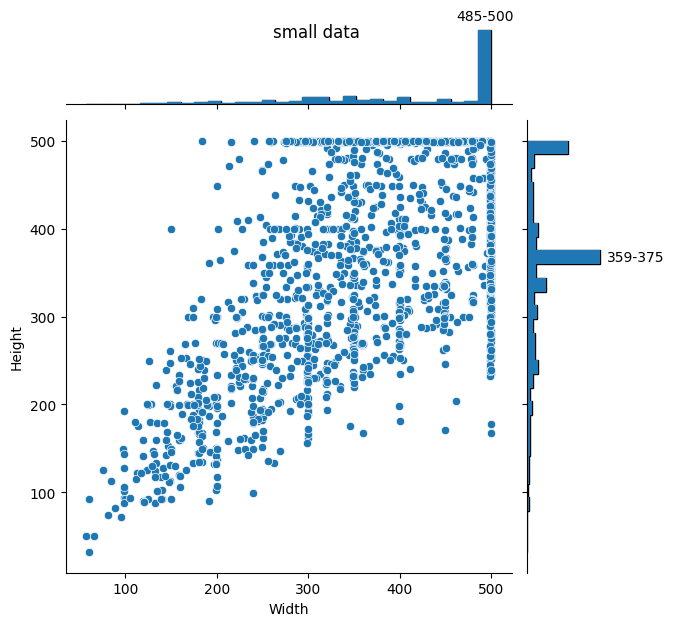

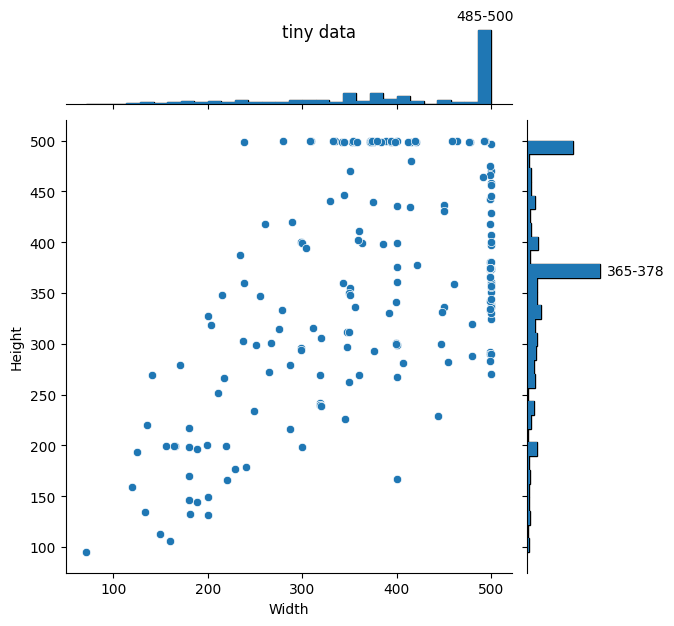

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.image import imread

def get_image_sizes(data_path):
    """Gather image dimensions for images in the specified directory."""
    sizes = []
    categories = ['train', 'val', 'test']
    for category in categories:
        cat_dir = data_path / category
        files = list(cat_dir.glob("*"))
        for image_path in files:
            img = imread(str(image_path))
            if len(img.shape) == 3:
                height, width, _ = img.shape
                sizes.append((width, height))
    return sizes

def plot_image_sizes(sizes, title):
    """Plot the image sizes using a jointplot and annotate the highest histogram bars with bin range."""
    widths, heights = zip(*sizes)
    widths = np.array(widths)
    heights = np.array(heights)

    # Create jointplot
    joint_plot = sns.jointplot(x=widths, y=heights, kind='scatter', marginal_kws=dict(bins=30, fill=True))
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.suptitle(title)

    # Annotate the highest bar in the x histogram
    n, bins, patches = joint_plot.ax_marg_x.hist(widths, bins=30, fill=True)
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_x.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=((max_bin_start + max_bin_end) / 2, max(n)), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

    # Annotate the highest bar in the y histogram
    n, bins, patches = joint_plot.ax_marg_y.hist(heights, bins=30, fill=True, orientation='horizontal')
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_y.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=(max(n), (max_bin_start + max_bin_end) / 2), xytext=(5, 0), textcoords='offset points', ha='left', va='center')

    plt.show()

# Setup paths
experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")

# Get sizes from each dataset
image_sizes_small = get_image_sizes(experiment_small_data)
image_sizes_tiny = get_image_sizes(experiment_tiny_data)

# Generate plots with annotations
plot_image_sizes(image_sizes_small, "small data ")
plot_image_sizes(image_sizes_tiny, "tiny data")


---
 b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver
slänga bilder. Hur kommer du fram till ditt val?

---
c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:
(samples, row, cols, color_channels) 


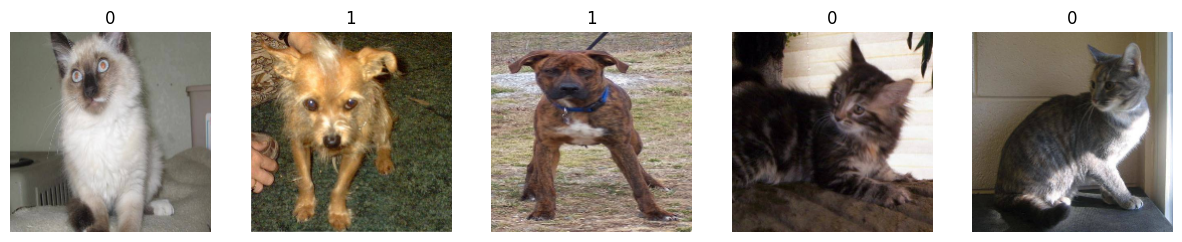

Shapes of Small Data:
X_train_small: (1600, 200, 200, 3)
y_train_small: (1600,)
X_test_small: (500, 200, 200, 3)
y_test_small: (500,)
X_val_small: (400, 200, 200, 3)
y_val_small: (400,)

Shapes of Tiny Data:
X_train_tiny: (160, 200, 200, 3)
y_train_tiny: (160,)
X_test_tiny: (50, 200, 200, 3)
y_test_tiny: (50,)
X_val_tiny: (40, 200, 200, 3)
y_val_tiny: (40,)


In [6]:
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# Define paths
current_path = Path('.')
small_data = current_path / "experiment_small_data"
tiny_data = current_path / "experiment_tiny_data"

small_train = small_data / "train"
small_test = small_data / "test"
small_val = small_data / "val"

tiny_train = tiny_data / "train"
tiny_test = tiny_data / "test"
tiny_val = tiny_data / "val"

# Get list of image paths
train_list = list(small_train.iterdir())
test_list = list(small_test.iterdir())
val_list = list(small_val.iterdir())
train_list_tiny = list(tiny_train.iterdir())
test_list_tiny = list(tiny_test.iterdir())
val_list_tiny = list(tiny_val.iterdir())

def label_and_resize_data(data, image_size=(200, 200)):
    """Labels the lists with 1 or 0 for dog and cat, resizes images to given size, and returns numpy arrays."""
    labels = []
    images = []
    np.random.shuffle(data)
    for path in data:
        label = 1 if "dog" in path.name else 0
        labels.append(label)

        image = cv2.imread(str(path))
        if image is not None:
            image = cv2.resize(image, image_size)
            images.append(image)

    return np.array(images), np.array(labels)

# Load, label, and resize the data
X_train_small, y_train_small = label_and_resize_data(train_list)
X_test_small, y_test_small = label_and_resize_data(test_list)
X_val_small, y_val_small = label_and_resize_data(val_list)

X_train_tiny, y_train_tiny = label_and_resize_data(train_list_tiny)
X_test_tiny, y_test_tiny = label_and_resize_data(test_list_tiny)
X_val_tiny, y_val_tiny = label_and_resize_data(val_list_tiny)

# Normalize the data
X_train_small = X_train_small / 255.0
X_test_small = X_test_small / 255.0
X_val_small = X_val_small / 255.0

X_train_tiny = X_train_tiny / 255.0
X_test_tiny = X_test_tiny / 255.0
X_val_tiny = X_val_tiny / 255.0

# Display random images
def display_random_images(images, labels, num_images=5):
    """Display a few random images with their labels."""
    indices = np.random.choice(np.arange(len(images)), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in zip(indices, axes):
        img = (images[i] * 255).astype(np.uint8)  # Convert back to uint8 for display
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f'{labels[i]}')
        ax.axis('off')
    plt.show()

display_random_images(X_train_small, y_train_small)

# Print shapes of datasets
print("Shapes of Small Data:")
print("X_train_small:", X_train_small.shape)
print("y_train_small:", y_train_small.shape)
print("X_test_small:", X_test_small.shape)
print("y_test_small:", y_test_small.shape)
print("X_val_small:", X_val_small.shape)
print("y_val_small:", y_val_small.shape)

print("\nShapes of Tiny Data:")
print("X_train_tiny:", X_train_tiny.shape)
print("y_train_tiny:", y_train_tiny.shape)
print("X_test_tiny:", X_test_tiny.shape)
print("y_test_tiny:", y_test_tiny.shape)
print("X_val_tiny:", X_val_tiny.shape)
print("y_val_tiny:", y_val_tiny.shape)


---






In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


c:\Users\lager\Desktop\Github\AI-Bjorn-Lagerblad-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.4856 - loss: 1.0263 - val_accuracy: 0.5050 - val_loss: 0.6896
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 384ms/step - accuracy: 0.5611 - loss: 0.6874 - val_accuracy: 0.5875 - val_loss: 0.6757
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.6009 - loss: 0.6615 - val_accuracy: 0.5275 - val_loss: 0.7125
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 375ms/step - accuracy: 0.6296 - loss: 0.6587 - val_accuracy: 0.5850 - val_loss: 0.6900
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - accuracy: 0.6661 - loss: 0.6180 - val_accuracy: 0.6425 - val_loss: 0.6400
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.7289 - loss: 0.5326 - val_accuracy: 0.6150 - val_loss: 0.7146
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 399ms/step - accuracy: 0.7792 - loss: 0.4705 - val_accuracy: 0.6225 - val_loss: 0.7733
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.8441 - loss: 0.3503 - val_accu

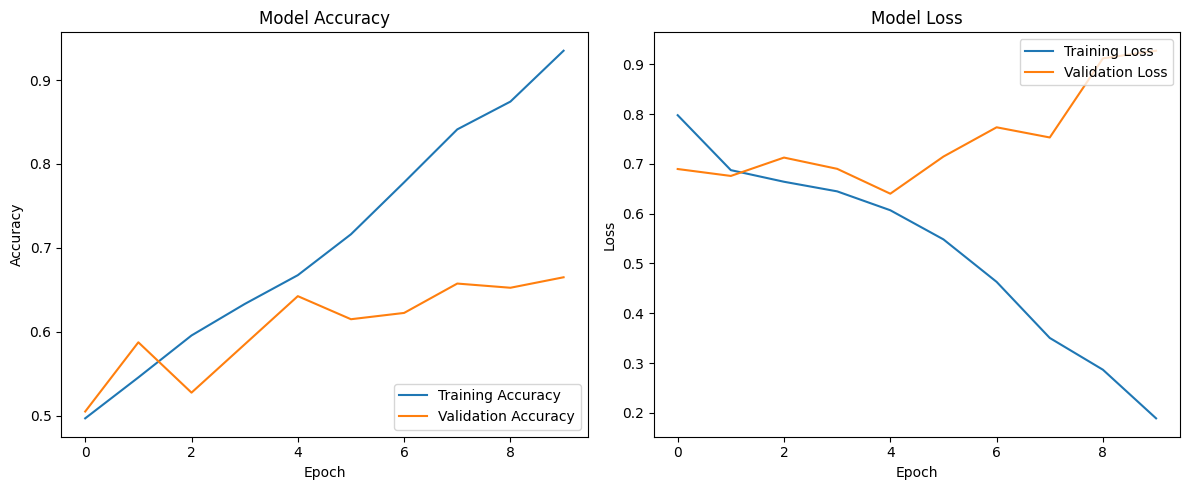

In [8]:


model_small = create_model()

history_small = model_small.fit(X_train_small, y_train_small, batch_size=32, epochs=10, 
                                validation_data=(X_val_small, y_val_small))

plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 1)  
plt.plot(history_small.history['accuracy'], label='Training Accuracy')
plt.plot(history_small.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(history_small.history['loss'], label='Training Loss')
plt.plot(history_small.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout() 
plt.show()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 397ms/step - accuracy: 0.4950 - loss: 1.1758 - val_accuracy: 0.5000 - val_loss: 0.6960
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - accuracy: 0.5118 - loss: 0.6923 - val_accuracy: 0.5375 - val_loss: 0.6892
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - accuracy: 0.5500 - loss: 0.6834 - val_accuracy: 0.5800 - val_loss: 0.6708
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - accuracy: 0.6290 - loss: 0.6429 - val_accuracy: 0.6050 - val_loss: 0.6677
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 410ms/step - accuracy: 0.6328 - loss: 0.6254 - val_accuracy: 0.6725 - val_loss: 0.5921
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.7181 - loss: 0.5397 - val_accuracy: 0.6800 - val_loss: 0.5891
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - accuracy: 0.7761 - loss: 0.4562 - val_accuracy: 0.7050 - val_loss: 0.6118
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 464ms/step - accuracy: 0.8402 - loss: 0.3633 - val_accu

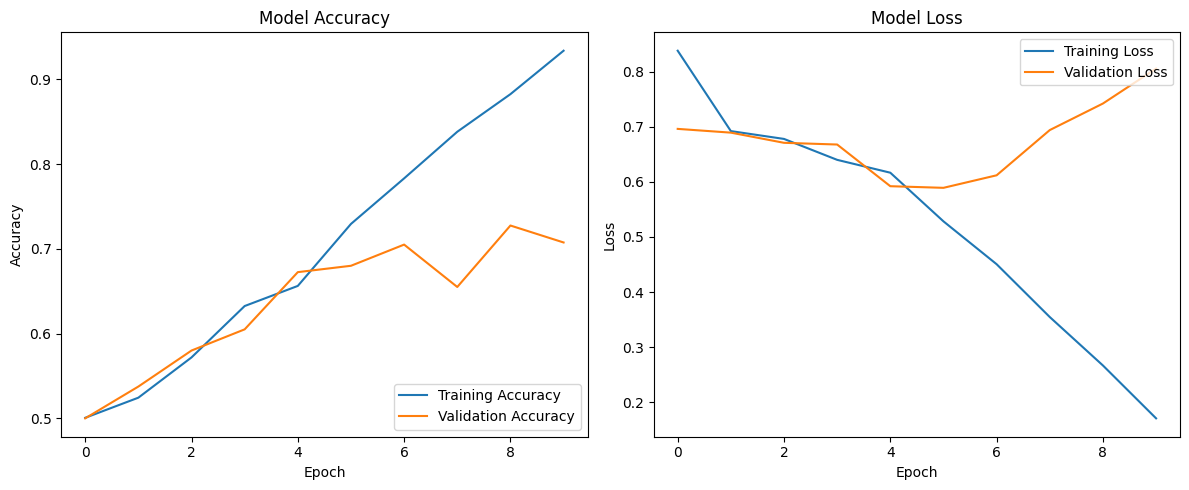

In [9]:
model_small = create_model()

history_small = model_small.fit(X_train_small, y_train_small, batch_size=32, epochs=10, 
                                validation_data=(X_val_small, y_val_small))

plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 1)  
plt.plot(history_small.history['accuracy'], label='Training Accuracy')
plt.plot(history_small.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(history_small.history['loss'], label='Training Loss')
plt.plot(history_small.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout() 
plt.show()

#test


---
---
 d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar du vilka parametrar du valt för
augmenteringen

Exempel på parametrar för bilddataaugmentering kan inkludera:

    Rotation: Bilden roteras med ett slumpmässigt vinkel.
    Skalning: Bildstorleken ändras genom zoomning in och ut.
    Horisontell/Vertikal spegling: Bilden speglas horisontellt eller vertikalt.
    Färgjustering: Ändringar i ljusstyrka, kontrast, mättnad, och nyans.

Shapes of Augmented Small Data:
X_train_small: (1600, 200, 200, 3)
y_train_small: (1600,)


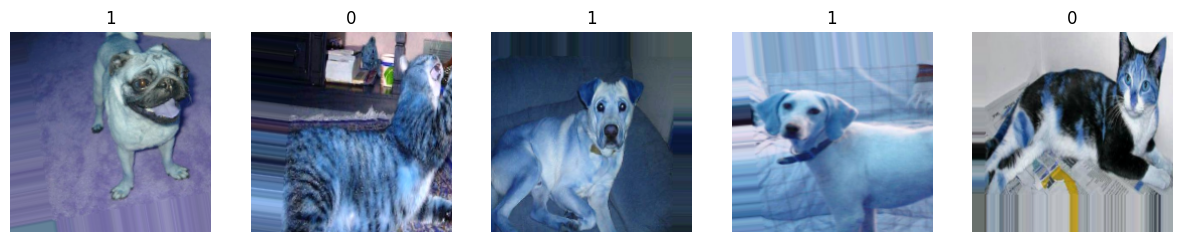

Shapes of Augmented Tiny Data:
X_train_tiny: (160, 200, 200, 3)
y_train_tiny: (160,)


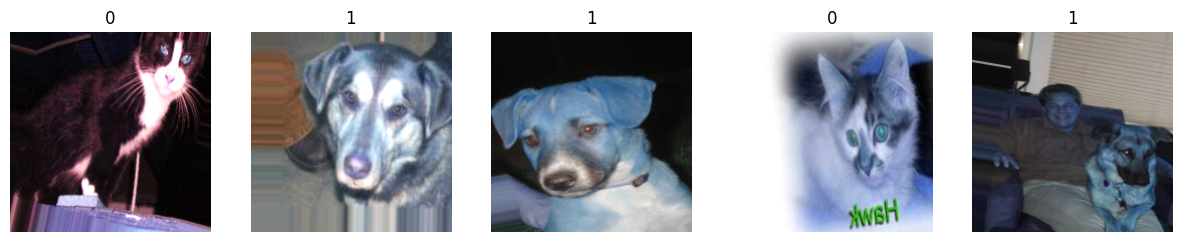

In [1]:
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
base_path = Path('.')
small_data = base_path / "experiment_small_data"
tiny_data = base_path / "experiment_tiny_data"

# Data Generator with additional augmentations
data_gen = ImageDataGenerator(
    rotation_range=10, 
    shear_range=0.2,    
    zoom_range=0.2,     
    horizontal_flip=True,
    height_shift_range=0.2, 
    width_shift_range=0.2,
)

def load_and_augment_images(data_path, image_size=(200, 200)):
    images = []
    labels = []
    for img_path in data_path.iterdir():
        label = 1 if 'dog' in img_path.name else 0
        image = cv2.imread(str(img_path))
        if image is not None:
            image = cv2.resize(image, image_size)
            image = np.expand_dims(image, axis=0)
            image = next(data_gen.flow(image, batch_size=1))[0]  # Augment image
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load and augment the data
X_train_small, y_train_small = load_and_augment_images(small_data / 'train')
X_train_tiny, y_train_tiny = load_and_augment_images(tiny_data / 'train')

# Normalize the data after augmentation
X_train_small = X_train_small / 255.0
X_train_tiny = X_train_tiny / 255.0

# Display augmented images
def display_augmented_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in zip(range(num_images), axes):
        idx = np.random.randint(0, len(images))
        ax.imshow(images[idx])
        ax.set_title(f'{labels[idx]}')
        ax.axis('off')
    plt.show()

# Display some augmented images
print("Shapes of Augmented Small Data:")
print("X_train_small:", X_train_small.shape)
print("y_train_small:", y_train_small.shape)
display_augmented_images(X_train_small, y_train_small)

print("Shapes of Augmented Tiny Data:")
print("X_train_tiny:", X_train_tiny.shape)
print("y_train_tiny:", y_train_tiny.shape)
display_augmented_images(X_train_tiny, y_train_tiny)

----

augmenterad data

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Validation data augmentation (without random transformations)
data_gen_val = ImageDataGenerator(rescale=1./255)

small_data_val = small_data / 'val'
X_val_small, y_val_small = load_and_augment_images(small_data_val, image_size=(200, 200))
X_val_small = X_val_small / 255.0

# Model definition with BatchNormalization
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom callback to remove learning rate from logs
class CustomReduceLROnPlateau(ReduceLROnPlateau):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if 'learning_rate' in logs:
            logs.pop('learning_rate')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = CustomReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model_small = create_model()

history_small = model_small.fit(
    X_train_small, y_train_small,
    batch_size=32,
    epochs=30,
    validation_data=(X_val_small, y_val_small),
    callbacks=[early_stopping, reduce_lr]
)

# Plotting the results
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history_small.history['accuracy'], label='Training Accuracy')
plt.plot(history_small.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2) 
plt.plot(history_small.history['loss'], label='Training Loss')
plt.plot(history_small.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout() 
plt.show()


Epoch 1/30


KeyboardInterrupt: 